In [1]:
DATA_ROOT = "/mnt/mc1/limbo"

... if you're running this notebook yourself, you'll need to set DATA_ROOT to point to a directory containing Limbo campaign data that you've downloaded.

Every campaign in the Limbo data is split into numbered subdirectories, each of which contains one thousand images, which we will use to load one thousand synthetic images for training, one thousand synthetic images for (synthetic) testing, and all of the available real-world data for (real) testing:

In [2]:
import os

import limbo.data

training_data = limbo.data.Dataset([os.path.join(DATA_ROOT, "campaign17", "0000")])
test_data = limbo.data.Dataset([os.path.join(DATA_ROOT, "campaign17", "0001")])
real_data = limbo.data.Dataset([os.path.join(DATA_ROOT, "ref", "0000")])

print(f"Loaded {len(training_data)} training images.")
print(f"Loaded {len(test_data)} test images.")
print(f"Loaded {len(real_data)} real images.")

Loaded 1000 training images.
Loaded 1000 test images.
Loaded 482 real images.


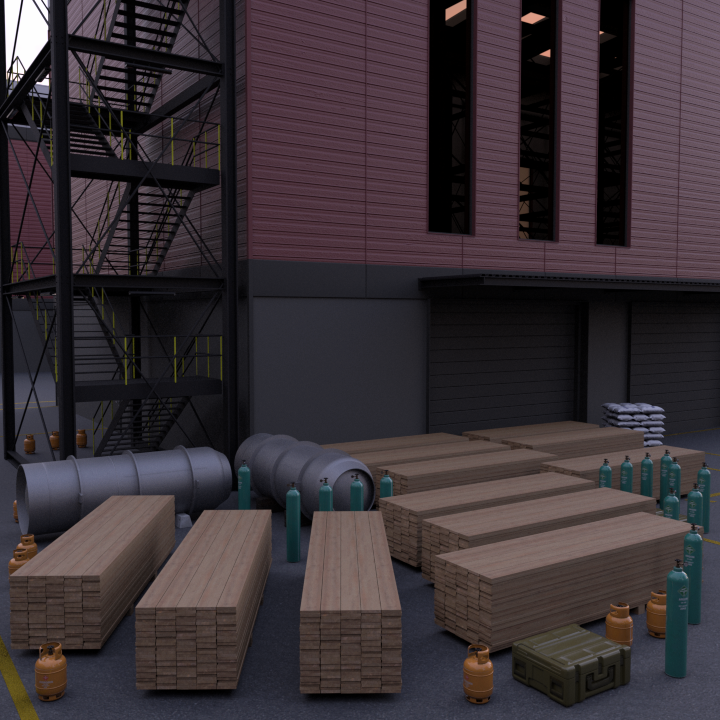

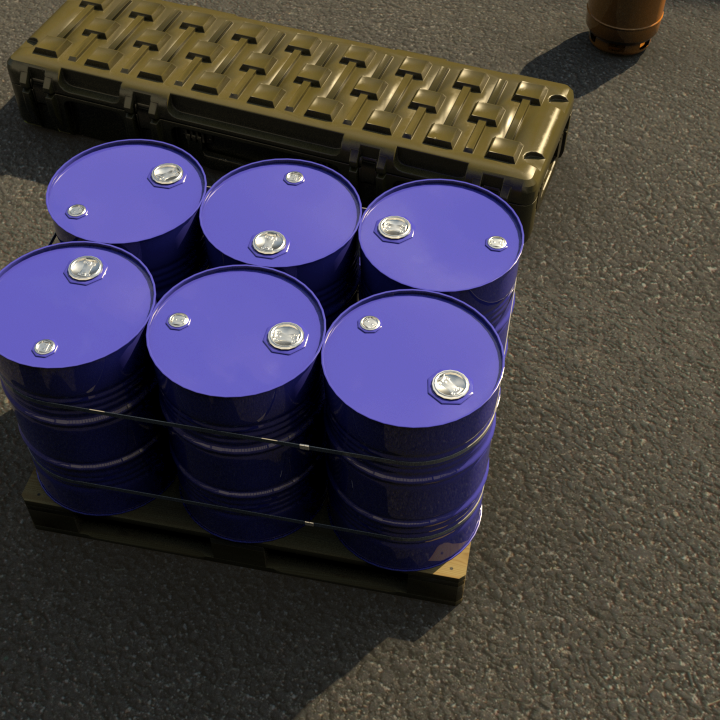

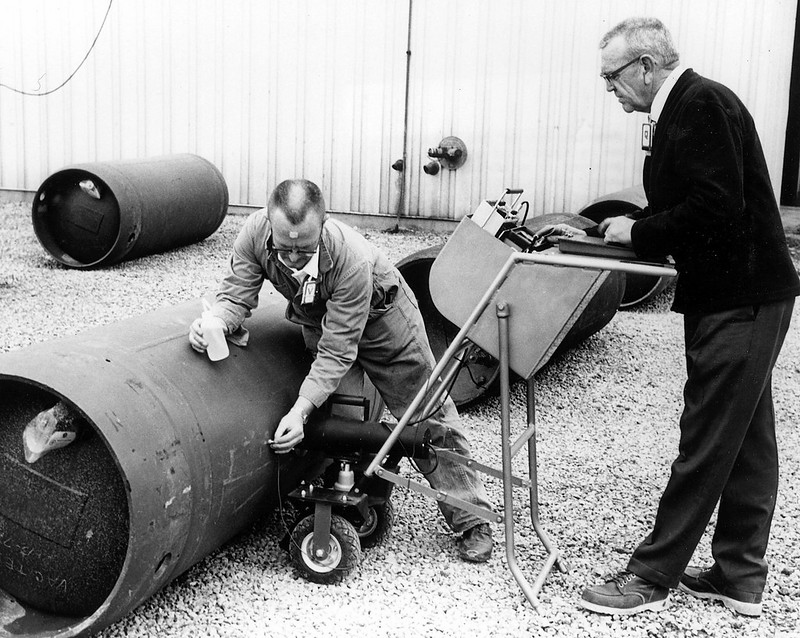

In [3]:
from IPython.display import display, HTML

display(HTML("<h3>Training sample<h3>"))
display(training_data[0].image)

display(HTML("<h3>Test sample<h3>"))
display(test_data[0].image)

display(HTML("<h3>Real sample<h3>"))
display(real_data[0].image)

In [4]:
import numpy

targets = set(["48G", "48X", "48Y"])

training_labels = [1 if sample.categories & targets else 0 for sample in training_data]
test_labels = [1 if sample.categories & targets else 0 for sample in test_data]
real_labels = [1 if sample.categories & targets else 0 for sample in real_data]

Since there are three styles of type 48 container in the dataset, we use Python set intersection to test whether a sample contains any of the three.

It's always a good idea to see how skewed your data is before you go too far, so let's figure out how many images contain our objects of interest:

In [44]:
print(f"{numpy.sum(training_labels) / len(training_labels):.1%} of training images have type 48 containers.")
print(f"{numpy.sum(test_labels) / len(test_labels):.1%} of test images have type 48 containers.")
print(f"{numpy.sum(real_labels) / len(real_labels):.1%} of real images have type 48 containers.")

60.6% of training images have containers.
60.1% of test images have containers.
19.3% of real images have containers.


An even mix of container and not-container images for training would be ideal, but ~60% containers isn't too bad, so we'll live with it for this demo. When conducting your own experiments, you will typically want to load more images than you need, downsampling based on the labels to achieve your desired balance between positive and negative examples.

Next, we need to wrap our Limbo dataset object to make it usable with PyTorch.  We'll create a simple adapter that loads Limbo training images on demand, resizes them to $224\times224$, and caches them in memory to speed-up training since our data is relatively small:

In [6]:
import torch.utils.data

class LimboToTorch(torch.utils.data.Dataset):
    def __init__(self, dataset, labels, transforms):
        self.dataset = dataset
        self.labels = numpy.expand_dims(labels, 1).astype(numpy.float32)
        self.transforms = transforms
        self.cache = {}

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, key):
        if key not in self.cache:
            sample = self.dataset[key]
            image = sample.image
            if "C" in image.layers:
                image = (image.layers["C"].data * 255).astype(numpy.uint8)
            elif "Y" in image.layers:
                image = numpy.tile(image.layers["Y"].data * 255, (1, 1, 3)).astype(numpy.uint8)
            image = torchvision.transforms.functional.to_pil_image(image, mode="RGB")
            image = torchvision.transforms.functional.resize(image, (224, 224))
            self.cache[key] = image
        return self.transforms(self.cache[key]), self.labels[key]

Next, we'll define a set of data augmentation transforms to apply to the images for training, and a much simpler set of transforms for evaluation:

In [7]:
import torchvision

training_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=90, scale=(0.8, 1.2), shear=20, interpolation=torchvision.transforms.InterpolationMode.BILINEAR, fill=(int(255*.485), int(255*.456), int(255*.406))),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

evaluation_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Now we can wrap our Limbo datasets for use with PyTorch:

In [9]:
training_data = LimboToTorch(training_data, training_labels, training_transforms)
test_data = LimboToTorch(test_data, test_labels, evaluation_transforms)
real_data = LimboToTorch(real_data, real_labels, evaluation_transforms)

We will hold back 20% of our training data for validation:

In [8]:
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2])

And create data loaders that can be used to iterate over the data in batches of 50 images:

In [10]:
training_loader = torch.utils.data.DataLoader(training_data, batch_size=50, shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=50, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=False, num_workers=0)
real_loader = torch.utils.data.DataLoader(real_data, batch_size=50, shuffle=False, num_workers=0)

Our model will be based on a Resnet-50 model pre-trained on Imagenet. Since our problem only requires a single "48 or not" output, we will replace the model's final, fully-connected output layer with one that produces a single sigmoid output. This output can be thought of as representing the model's confidence that an image contains a type 48 container, and nicely coincides with the "1" and "0" labels we created earlier.

In [17]:
model = torchvision.models.resnet50(weights="IMAGENET1K_V2")

model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 1),
    torch.nn.Sigmoid(),
)

We will train using nVidia GPU hardware; if you don't have any, you can change the following to the string `"cpu"`, but your training times will be *very* long:

In [ ]:
DEVICE = "cuda"

With DEVICE set, we can prepare our model for use on the hardware, and setup our loss function and optimizer:

In [12]:
model = model.to(DEVICE)
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [15]:
import collections

import sklearn.metrics

metrics = collections.defaultdict(list)

epochs = numpy.arange(500)
for epoch in epochs:
    if not epoch % 10 or epoch < 10:
        print("*" * 80)
        print(f"epoch: {epoch}")
    
    # Train the model
    losses = []
    y_true = []
    y_pred = []
    model.train(True)

    for x, y in training_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        y_hat = model(x)
        loss = loss_function(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        y_true.append(y.cpu().detach())
        y_pred.append(y_hat.cpu().detach())

    losses = numpy.row_stack(losses)
    y_true = numpy.row_stack(y_true)
    y_pred = numpy.row_stack(y_pred)

    metrics["training/loss"].append(numpy.mean(losses))
    metrics["training/accuracy"].append(sklearn.metrics.accuracy_score(y_true, y_pred > 0.5))
    metrics["training/precision"].append(sklearn.metrics.precision_score(y_true, y_pred > 0.5))
    metrics["training/recall"].append(sklearn.metrics.recall_score(y_true, y_pred > 0.5))
    
    # Validate the model
    losses = []
    y_true = []
    y_pred = []
    model.train(False)

    for x, y in validation_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        y_hat = model(x)
        loss = loss_function(y_hat, y)
        losses.append(loss.item())
        y_true.append(y.cpu().detach())
        y_pred.append(y_hat.cpu().detach())

    losses = numpy.row_stack(losses)
    y_true = numpy.row_stack(y_true)
    y_pred = numpy.row_stack(y_pred)

    metrics["validation/loss"].append(numpy.mean(losses))
    metrics["validation/accuracy"].append(sklearn.metrics.accuracy_score(y_true, y_pred > 0.5))
    metrics["validation/precision"].append(sklearn.metrics.precision_score(y_true, y_pred > 0.5))
    metrics["validation/recall"].append(sklearn.metrics.recall_score(y_true, y_pred > 0.5))

    # Test the model on synthetic data
    losses = []
    y_true = []
    y_pred = []
    model.train(False)

    for x, y in test_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        y_hat = model(x)
        loss = loss_function(y_hat, y)
        losses.append(loss.item())
        y_true.append(y.cpu().detach())
        y_pred.append(y_hat.cpu().detach())

    losses = numpy.row_stack(losses)
    y_true = numpy.row_stack(y_true)
    y_pred = numpy.row_stack(y_pred)

    metrics["test/loss"].append(numpy.mean(losses))
    metrics["test/accuracy"].append(sklearn.metrics.accuracy_score(y_true, y_pred > 0.5))
    metrics["test/precision"].append(sklearn.metrics.precision_score(y_true, y_pred > 0.5))
    metrics["test/recall"].append(sklearn.metrics.recall_score(y_true, y_pred > 0.5))

    # Test the model on real data
    losses = []
    y_true = []
    y_pred = []
    model.train(False)

    for x, y in real_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        y_hat = model(x)
        loss = loss_function(y_hat, y)
        losses.append(loss.item())
        y_true.append(y.cpu().detach())
        y_pred.append(y_hat.cpu().detach())

    losses = numpy.row_stack(losses)
    y_true = numpy.row_stack(y_true)
    y_pred = numpy.row_stack(y_pred)

    metrics["real/loss"].append(numpy.mean(losses))
    metrics["real/accuracy"].append(sklearn.metrics.accuracy_score(y_true, y_pred > 0.5))
    metrics["real/precision"].append(sklearn.metrics.precision_score(y_true, y_pred > 0.5))
    metrics["real/recall"].append(sklearn.metrics.recall_score(y_true, y_pred > 0.5))

    
    if not epoch % 10 or epoch < 10:
        print(f"{'':>16}{'loss':<10}{'accuracy':<10}{'precision':<10}{'recall':<10}")

        print(f"{'training: ':>16}", end="")
        print(f"{metrics['training/loss'][-1]:<10.3f}", end="")
        print(f"{metrics['training/accuracy'][-1]:<10.3f}", end="")
        print(f"{metrics['training/precision'][-1]:<10.3f}", end="")
        print(f"{metrics['training/recall'][-1]:<10}")

        print(f"{'validation: ':>16}", end="")
        print(f"{metrics['validation/loss'][-1]:<10.3f}", end="")
        print(f"{metrics['validation/accuracy'][-1]:<10.3f}", end="")
        print(f"{metrics['validation/precision'][-1]:<10.3f}", end="")
        print(f"{metrics['validation/recall'][-1]:<10}")

        print(f"{'test: ':>16}", end="")
        print(f"{metrics['test/loss'][-1]:<10.3f}", end="")
        print(f"{metrics['test/accuracy'][-1]:<10.3f}", end="")
        print(f"{metrics['test/precision'][-1]:<10.3f}", end="")
        print(f"{metrics['test/recall'][-1]:<10}")

        print(f"{'real: ':>16}", end="")
        print(f"{metrics['real/loss'][-1]:<10.3f}", end="")
        print(f"{metrics['real/accuracy'][-1]:<10.3f}", end="")
        print(f"{metrics['real/precision'][-1]:<10.3f}", end="")
        print(f"{metrics['real/recall'][-1]:<10}")

********************************************************************************
epoch: 0
                loss      accuracy  precision recall    
      training: 0.701     0.450     0.576     0.3450413223140496
    validation: 0.690     0.525     0.648     0.48360655737704916
          test: 0.709     0.412     0.517     0.3211314475873544
          real: 0.669     0.697     0.322     0.5161290322580645
********************************************************************************
epoch: 1
                loss      accuracy  precision recall    
      training: 0.694     0.505     0.602     0.5351239669421488
    validation: 0.692     0.505     0.604     0.5491803278688525
          test: 0.701     0.470     0.571     0.47587354409317806
          real: 0.687     0.568     0.255     0.6451612903225806
********************************************************************************
epoch: 2
                loss      accuracy  precision recall    
      training: 0.688     0.551     0

********************************************************************************
epoch: 120
                loss      accuracy  precision recall    
      training: 0.559     0.725     0.701     0.9504132231404959
    validation: 0.563     0.695     0.683     0.9344262295081968
          test: 0.573     0.682     0.661     0.9683860232945092
          real: 0.985     0.207     0.195     0.989247311827957
********************************************************************************
epoch: 130
                loss      accuracy  precision recall    
      training: 0.548     0.723     0.707     0.9256198347107438
    validation: 0.570     0.715     0.712     0.8934426229508197
          test: 0.565     0.691     0.669     0.9633943427620633
          real: 0.996     0.212     0.195     0.989247311827957
********************************************************************************
epoch: 140
                loss      accuracy  precision recall    
      training: 0.540     0.726    

                loss      accuracy  precision recall    
      training: 0.388     0.825     0.840     0.878099173553719
    validation: 0.516     0.705     0.765     0.7459016393442623
          test: 0.453     0.777     0.768     0.9018302828618968
          real: 1.119     0.299     0.210     0.956989247311828
********************************************************************************
epoch: 330
                loss      accuracy  precision recall    
      training: 0.377     0.829     0.836     0.8925619834710744
    validation: 0.479     0.785     0.811     0.8442622950819673
          test: 0.448     0.785     0.777     0.9018302828618968
          real: 1.134     0.303     0.210     0.946236559139785
********************************************************************************
epoch: 340
                loss      accuracy  precision recall    
      training: 0.375     0.844     0.864     0.8801652892561983
    validation: 0.486     0.755     0.779     0.836065573770491

Let's plot these results, so we can look for any broad trends ...

In [41]:
import toyplot

canvas = toyplot.Canvas(width=1000, height=600)
axes = canvas.cartesian(grid=(2, 2, 0), xlabel="Epoch", ylabel="Loss")
training = axes.plot(epochs, metrics["training/loss"])
validation = axes.plot(epochs, metrics["validation/loss"])
test = axes.plot(epochs, metrics["test/loss"])
real = axes.plot(epochs, metrics["real/loss"])

axes = canvas.cartesian(grid=(2, 2, 1), xlabel="Epoch", ylabel="Accuracy")
training = axes.plot(epochs, metrics["training/accuracy"])
validation = axes.plot(epochs, metrics["validation/accuracy"])
test = axes.plot(epochs, metrics["test/accuracy"])
real = axes.plot(epochs, metrics["real/accuracy"])

axes = canvas.cartesian(grid=(2, 2, 2), xlabel="Epoch", ylabel="Precision")
training = axes.plot(epochs, metrics["training/precision"])
validation = axes.plot(epochs, metrics["validation/precision"])
test = axes.plot(epochs, metrics["test/precision"])
real = axes.plot(epochs, metrics["real/precision"])

axes = canvas.cartesian(grid=(2, 2, 3), xlabel="Epoch", ylabel="Recall")
training = axes.plot(epochs, metrics["training/recall"])
validation = axes.plot(epochs, metrics["validation/recall"])
test = axes.plot(epochs, metrics["test/recall"])
real = axes.plot(epochs, metrics["real/recall"])

title = "Training {} validation {} test {} and real {} metrics".format(
    training.markers[0],
    validation.markers[0],
    test.markers[0],
    real.markers[0],
)
canvas.text(500, 30, text=title, style={"font-size": "16px", "font-weight":"bold"});

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1000.0px" height="600.0px" viewBox="0 0 1000.0 600.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td8c7cf5ab9d64ae4bbbeb141bca50df1"> <path d="M 50.0 166.56580455601215 L 50.8 167.72627284129462 L 51.599999999999994 168.58849376440048 L 52.400000000000006 169.48939375579357 L 53.2 169.86718724171322 L 54.0 169.70767776171368 L 54.8 171.10608344276747 L 55.599999999999994 171.37119807302952 L 56.400000000000006 171.49208498497805 L 57.2 172.13622306783995 L 58.0 172.24744719763598 L 58.8 173.18791846434277 L 59.599999999999994 172.68126159906387 L 60.39999999999999 173.44874652723473 L 61.2 172.85128509004912 L 62.0 173.79668119053048 L 62.8 173.84534838298958 L 63.599999999999994 174.39253206054372 L 64.39999999999999 174.20602043469748 L 65.2 174.55128468573093 L 66.0 174.86758294204873 L 66.8 174.98169106741747 L 67.6 174.34579270581406 L 68.39999999999999 174.97533448040485 L 69.19999999999999 175.90539356072745 L 70.0 175.2894528210163 L 70.8 175.35383142530918 L 71.6 176.1077929288149 L 72.39999999999999 176.32678598165512 L 73.19999999999999 176.56472648183507 L 74.0 176.49820831914744 L 74.8 176.18890615801018 L 75.6 176.36376197139424 L 76.4 176.46273983021578 L 77.19999999999999 176.13886184990406 L 78.0 177.02135083576044 L 78.80000000000001 177.1481255690257 L 79.6 177.6061773300171 L 80.4 177.68725268542767 L 81.2 177.65470234056315 L 82.0 178.2051065315803 L 82.8 177.9919336239497 L 83.60000000000001 178.43295832475027 L 84.4 178.1365754703681 L 85.19999999999999 178.02127587298554 L 86.0 179.18753574291867 L 86.8 178.43200402955216 L 87.6 178.74895110726357 L 88.4 178.98799367249012 L 89.2 179.07439122597378 L 90.0 178.72646152973175 L 90.8 179.4940712551276 L 91.6 180.4485309869051 L 92.4 179.30284899969897 L 93.2 180.14994710683823 L 94.0 179.53512519598007 L 94.8 180.49020705123743 L 95.6 180.0876472145319 L 96.4 180.22782678405446 L 97.19999999999999 180.35789591570696 L 98.0 181.21052235364914 L 98.8 180.89433399339518 L 99.6 181.13691558440527 L 100.4 181.15783681472143 L 101.2 181.52204354604086 L 102.0 181.79920700689158 L 102.80000000000001 180.54397416611513 L 103.6 182.09543091555437 L 104.4 181.47795846064886 L 105.20000000000002 181.97802466650805 L 106.0 182.57379420101643 L 106.79999999999998 181.78669065237045 L 107.6 182.13724109033745 L 108.4 182.97030478715897 L 109.19999999999999 182.67550393939018 L 110.0 182.7462968726953 L 110.79999999999998 183.5383811344703 L 111.6 182.88006025056046 L 112.4 182.93816981216273 L 113.19999999999999 183.9185376962026 L 114.0 184.25415779153508 L 114.80000000000001 184.25256460905075 L 115.6 183.66819508373737 L 116.4 184.09810351828736 L 117.20000000000002 183.96633317073187 L 118.0 184.351862842838 L 118.8 184.7399778664112 L 119.6 184.46748219430447 L 120.39999999999999 185.24680299063525 L 121.19999999999999 184.69622929890951 L 122.0 184.89309412737688 L 122.8 185.49894864360493 L 123.6 185.74681921551627 L 124.4 185.47845520079136 L 125.19999999999999 185.61438793937367 L 126.0 186.51628009974957 L 126.80000000000001 186.99680529534817 L 127.6 186.6658135627707 L 128.4 186.20249268909296 L 129.20000000000002 187.1584866195917 L 130.0 186.97257849077386 L 130.8 188.15610880653065 L 131.6 186.75946642955145 L 132.39999999999998 187.69675133128962 L 133.2 186.80270773669085 L 134.0 187.16219514608383 L 134.79999999999998 188.51901292800903 L 135.6 188.17816376686096 L 136.4 188.1652065863212 L 137.2 188.54858055710793 L 138.0 187.92180108527344 L 138.8 187.93355375528336 L 139.6 188.05506465335688 L 140.4 189.03613723814487 L 141.20000000000002 189

Looking at the training, validation, and test results (using synthetic data), we see patterns that are typical of a successful model:

* Training loss steadily decreases, while validation and test loss decrease to a minimum point before starting to trend upwards (around epoch 425 in this case).  Under normal circumstances, we might stop training at this point to avoid overfitting.

* Accuracy steadily increases to around 80% (for the test data), while precision and recall eventually reach a good balance (around 81% and 85% respectively).

* Overall, we can have confidence that the train synthetic, test synthetic use case is working as it should.

For the real-world results (using real images), there are interesting patterns that we commonly find with the train synthetic, test real use-case:

* The real loss function steadily *increases* (the opposite of what we would like) - this highlights the fact that the synthetic and real images are drawn from different distributions, even though the synthetic data is often mistaken for real data by humans.

* In spite of this, and after an initial low-precision, high-recall configuration, we see gradual balancing of precision and recall, leading to steady improvements in accuracy.  Although the accuracy is relatively low (around 39%), is is still twice as high as the expected accuracy for random chance (around 19%; the proportion of real images that contain type-48 containers).

* Furthermore, some of the poor precision can be traced to our decision to train only on type 48 containers; since the real data contains both 30B and type 48 containers, it's likely that the model is confusing 30B containers for type 48 containers, something we could address by training using examples of each.

* Even though our validation curve hits a minimum around epoch 425, the metrics on real-world data are still improving as of epoch 500, suggesting that further training could be useful.